In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from keras.utils import pad_sequences
import os



In [37]:
data = pd.read_csv("Stress.csv")

In [38]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [39]:
data.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005


In [40]:
print("The dataset has", data.shape[0], "rows and", data.shape[1], "columns.")

data.info()

The dataset has 2838 rows and 7 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subreddit         2838 non-null   object 
 1   post_id           2838 non-null   object 
 2   sentence_range    2838 non-null   object 
 3   text              2838 non-null   object 
 4   label             2838 non-null   int64  
 5   confidence        2838 non-null   float64
 6   social_timestamp  2838 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 155.3+ KB


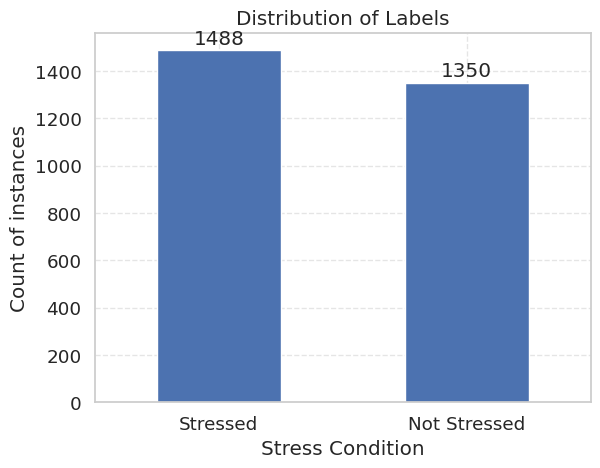

In [41]:
ax = data.label.value_counts().plot(kind='bar')
ax.set_xticks(ticks=[0, 1], labels=['Stressed', 'Not Stressed'], rotation=0)
plt.ylabel('Count of instances')
plt.xlabel('Stress Condition')
plt.title('Distribution of Labels')

counts = data.label.value_counts()
for i, count in enumerate(counts):
    ax.text(i, count + 10, str(count), ha='center', va='bottom')

plt.grid(True, linestyle='--', which='both', alpha=0.5)

plt.show()


<ipython-input-42-c1fffbdc71e5>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  chart.set_xticklabels(labels=['Not Stressed','Stressed'],rotation=0)


[Text(0, 0, 'Not Stressed'), Text(1, 0, 'Stressed')]

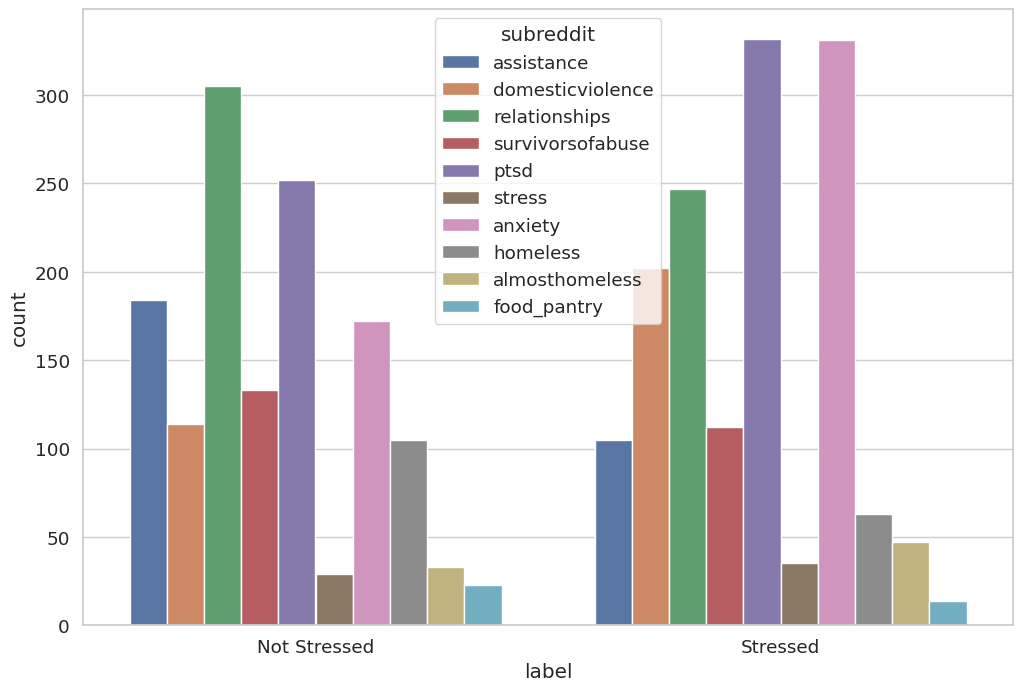

In [42]:
plt.figure(figsize = (12,8))
sns.set(style = "whitegrid",font_scale = 1.2)
chart = sns.countplot(x = "label", hue = "subreddit" , data = data)
chart.set_xticklabels(labels=['Not Stressed','Stressed'],rotation=0)

In [43]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

wnl = WordNetLemmatizer()
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
data["text"] = data["text"].apply(remove_stopwords)

data["text"] = data["text"].apply(lambda x: " ".join([wnl.lemmatize(word) for word in x.split()]))

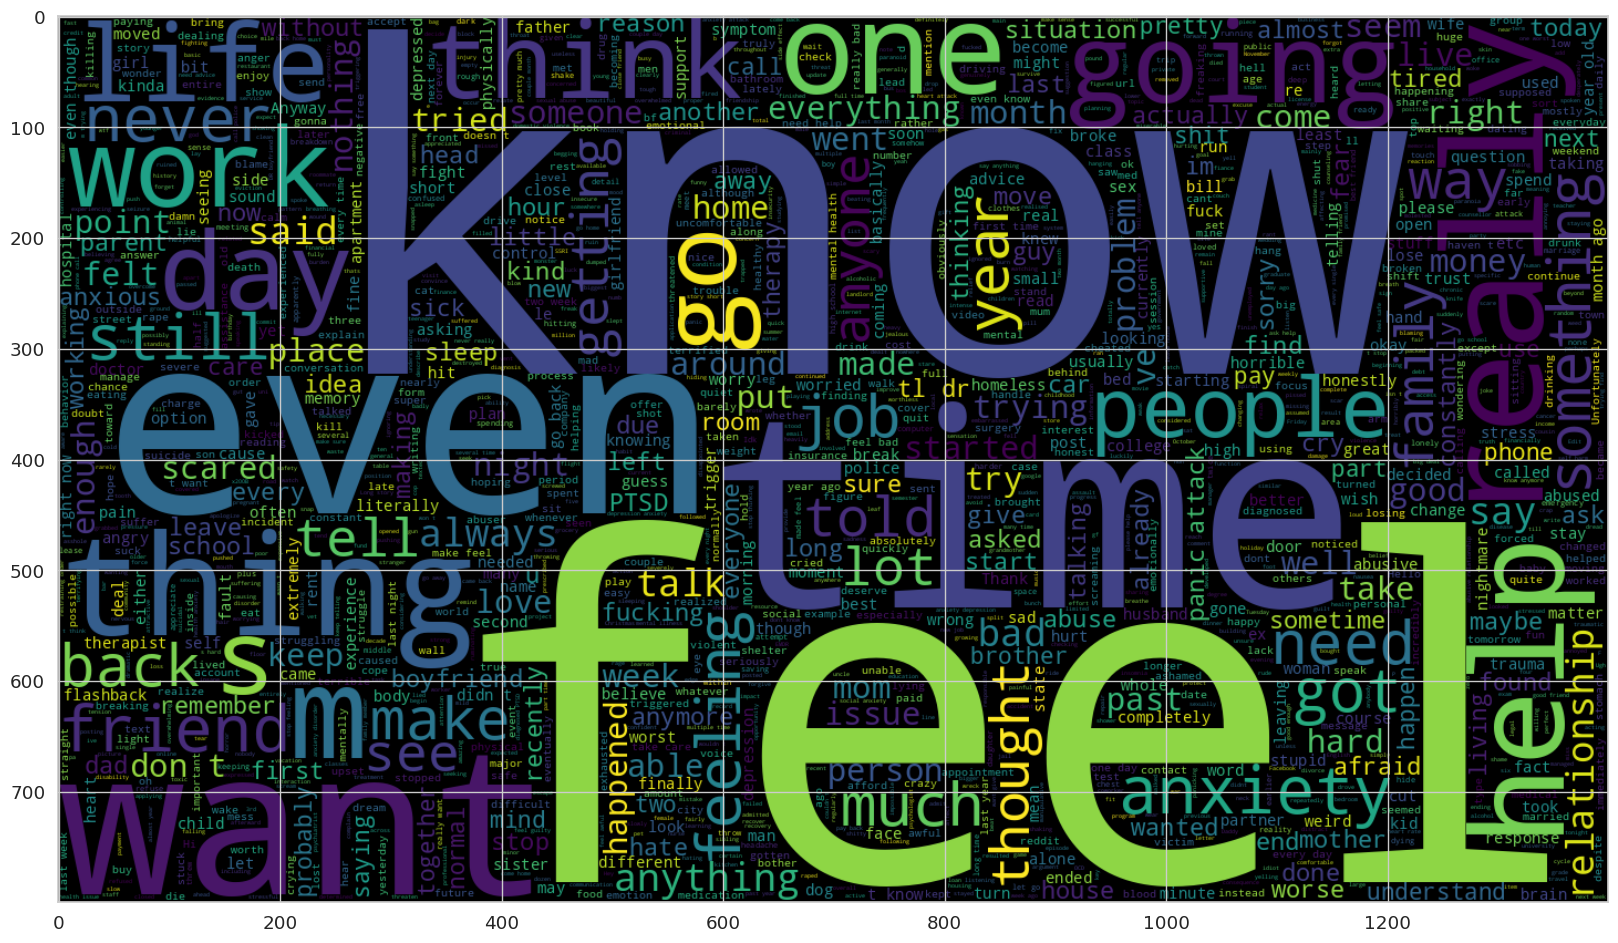

In [44]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 3000 , width = 1400 , height = 800, stopwords = STOPWORDS).generate(" ".join(data[data.label == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

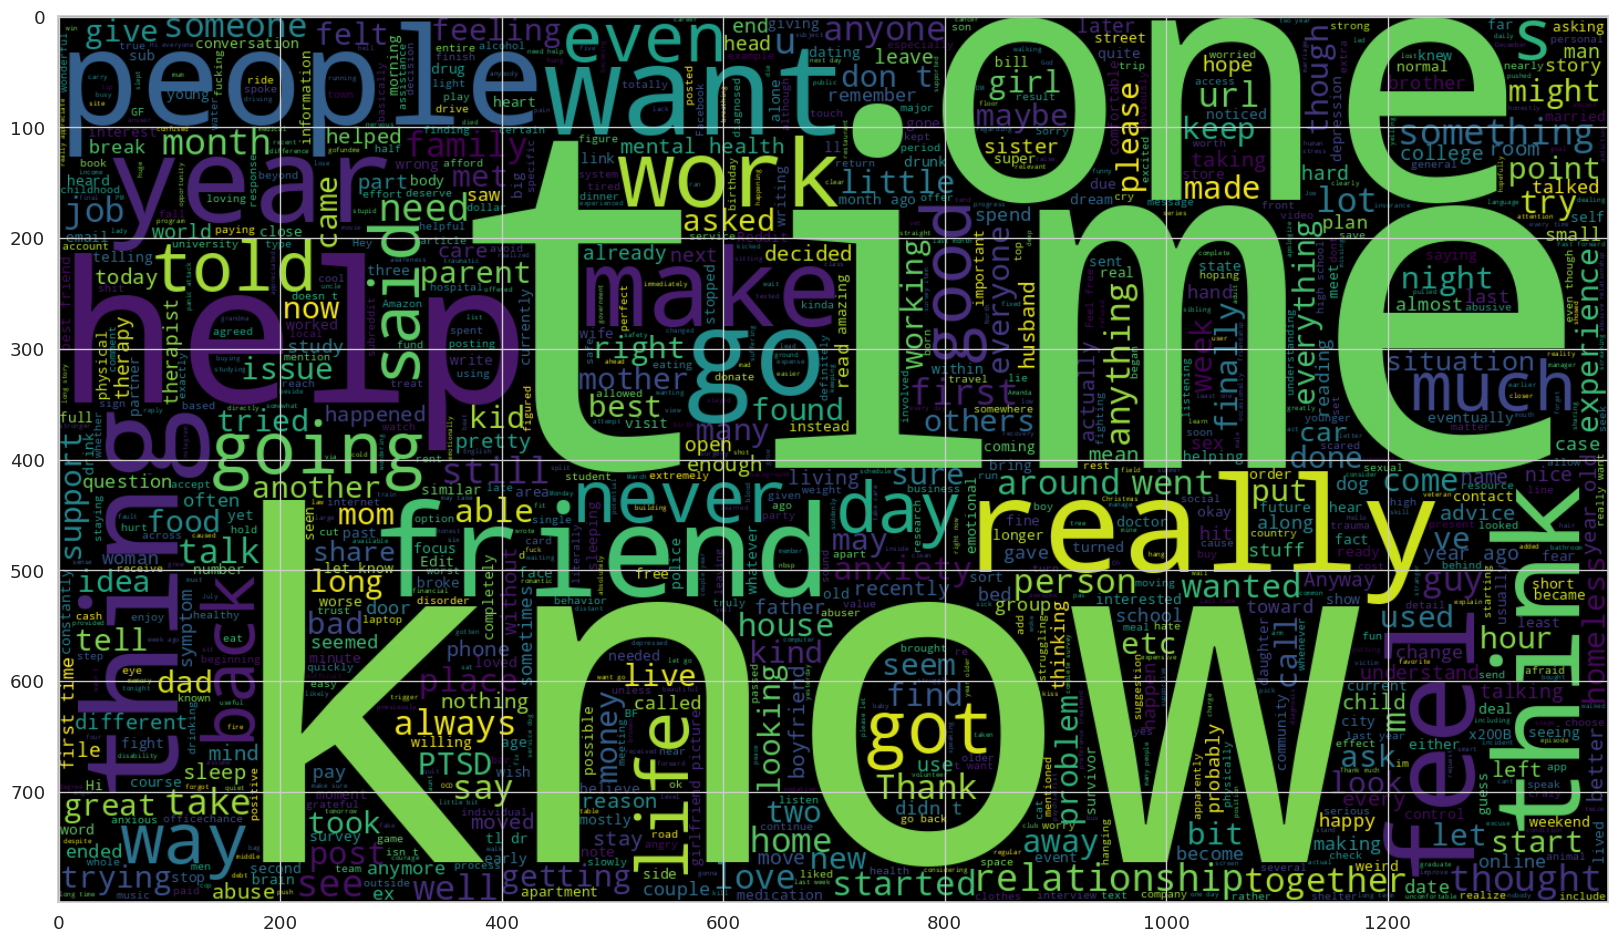

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1400 , height = 800 , stopwords = STOPWORDS).generate(" ".join(data[data.label == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

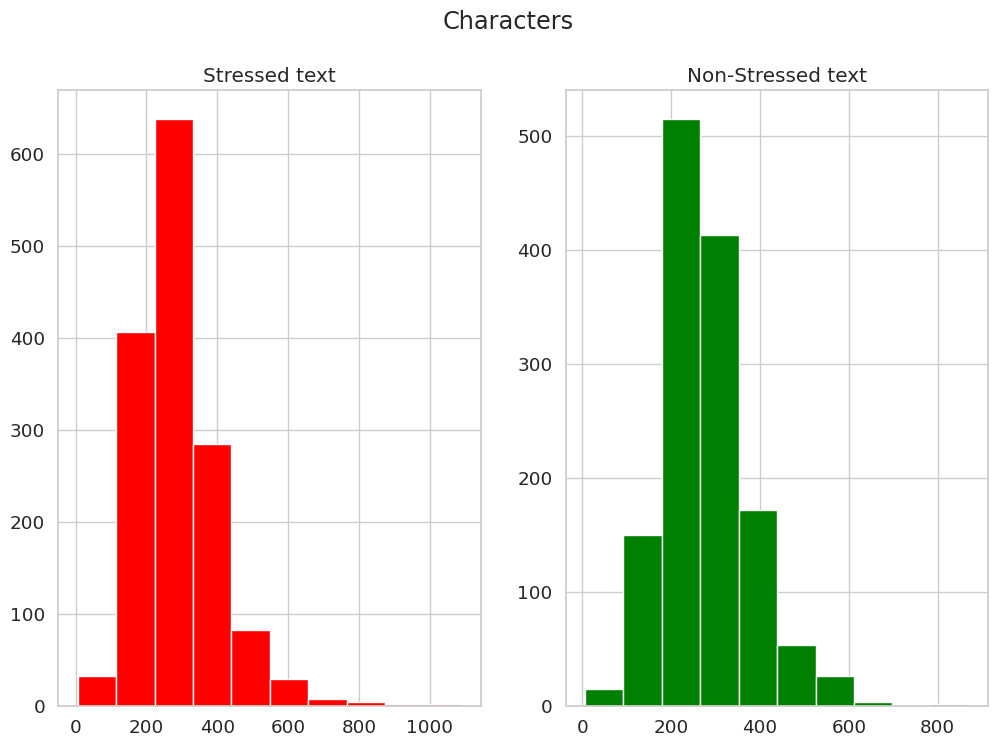

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=data[data['label']==1]['text'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Stressed text')
text_len=data[data['label']==0]['text'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Non-Stressed text')
fig.suptitle('Characters')
plt.show()

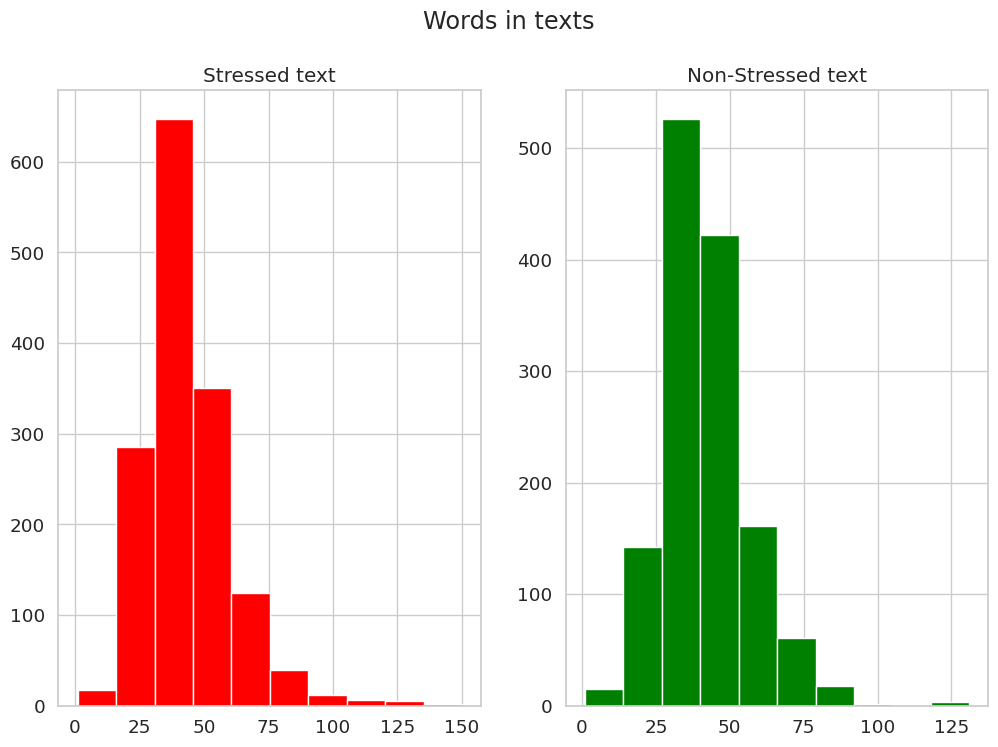

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=data[data['label']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Stressed text')
text_len=data[data['label']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Non-Stressed text')
fig.suptitle('Words in texts')
plt.show()

In [ ]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(20)
most_common = dict(most_common)


def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(data.text)
corpus[:5]

['said', 'felt', 'way', 'before,', 'suggeted']

In [ ]:
most_common

{"I'm": 1201,
 'like': 1122,
 'get': 905,
 'feel': 828,
 'know': 819,
 'would': 737,
 'time': 666,
 'want': 629,
 'really': 612,
 'even': 527,
 'year': 505,
 'one': 502,
 'go': 500,
 "I've": 479,
 'thing': 447,
 'going': 437,
 'help': 422,
 'make': 421,
 'think': 419,
 'I’m': 396}

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<Axes: >

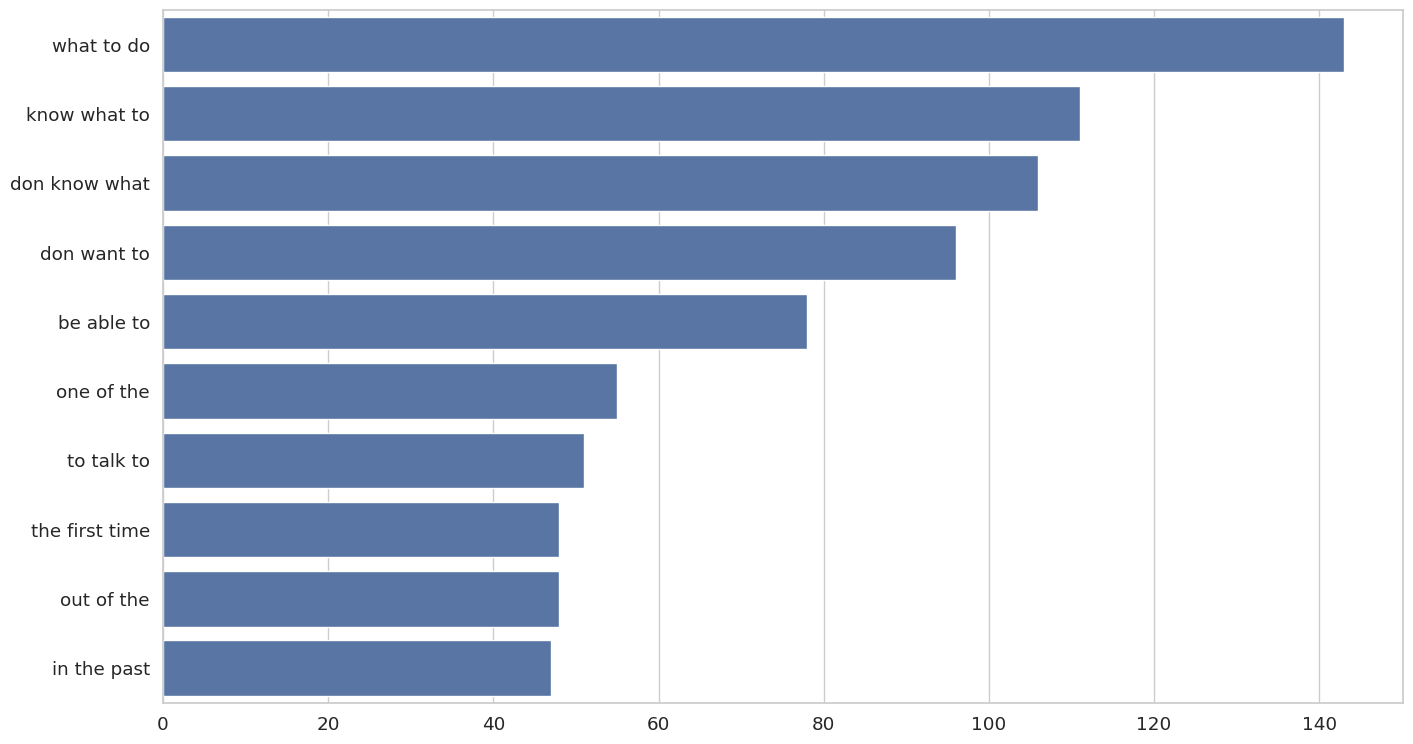

In [ ]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(data.text,10,3)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

<Axes: >

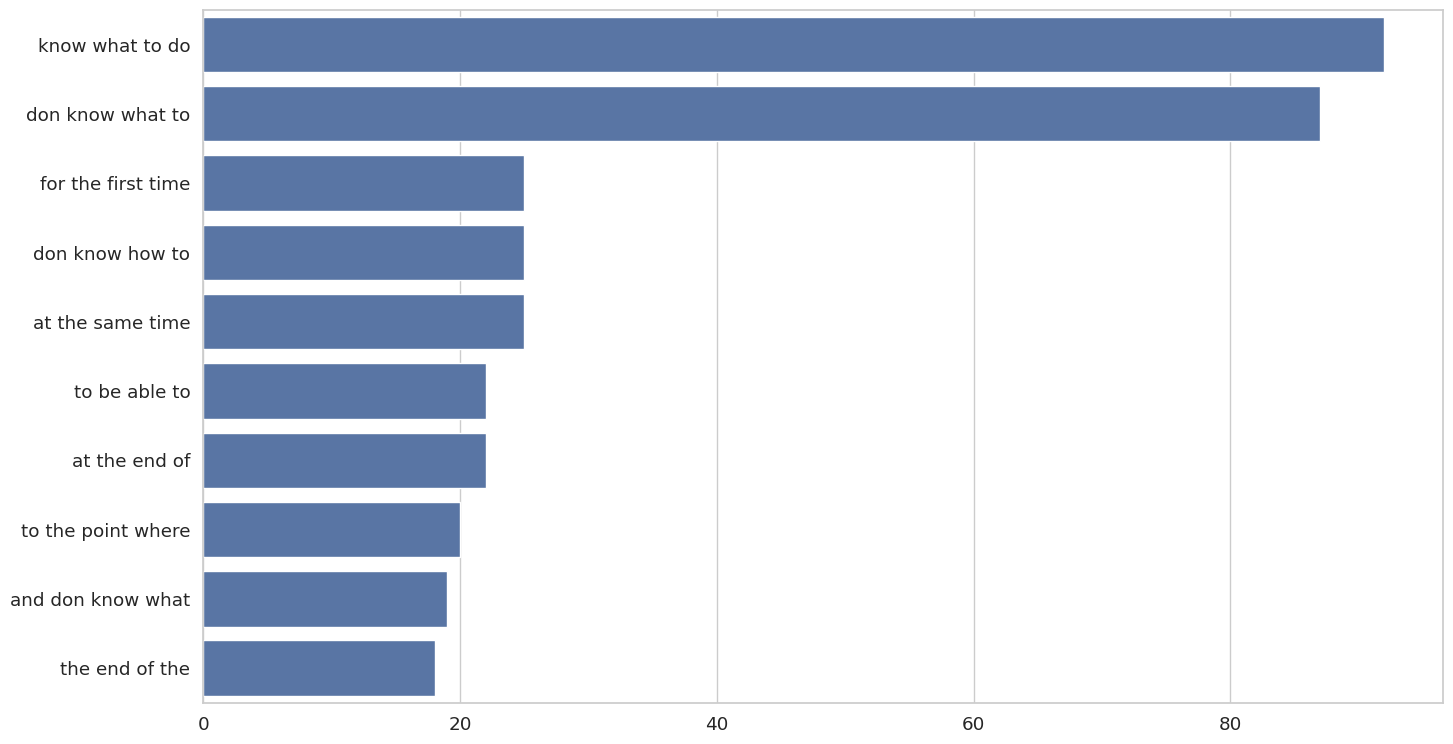

In [ ]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(data.text,10,4)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))